# LGBMRegressor

In [2]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

In [3]:
train = pd.read_csv('energy/train.csv', encoding='cp949')
test = pd.read_csv('energy/test.csv', encoding='cp949')

In [4]:
train[['num', '비전기냉방설비운영', '태양광보유']]
ice = {}
hot = {}
count = 0

for i in range(0, len(train), len(train)//60):
    count += 1
    ice[count] = train.loc[i, '비전기냉방설비운영']
    hot[count] = train.loc[i, '태양광보유']

for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영'] = ice[test['num'][i]]
    test.loc[i, '태양광보유'] = hot[test['num'][i]]

In [5]:
def time(x):
    return int(x[-2:])

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()

train['time'] = train['date_time'].apply(lambda x: time(x))
train['weekday'] = train['date_time'].apply(lambda x: weekday(x))
test['time'] = test['date_time'].apply(lambda x: time(x))
test['weekday'] = test['date_time'].apply(lambda x: weekday(x))

test = test.interpolate(method='values')

train_drop = train.drop('date_time', axis=1)
test_drop = test.drop('date_time', axis=1)

In [116]:
features = train_drop.drop('전력사용량(kWh)', axis=1)
target = train_drop[['전력사용량(kWh)']]

In [117]:
features.shape

(122400, 10)

In [118]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
fold = 1
models = {}

for train_idx, valid_idx in kfold.split(train):
    print('\n ##### Fold {} #####'.format(fold))

    X_train, X_valid = features.iloc[train_idx, :], features.iloc[valid_idx, :]
    y_train, y_valid = target.iloc[train_idx, :], target.iloc[valid_idx, :]

    model = LGBMRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=30, verbose=50)
    models[fold] = model

    fold += 1


 ##### Fold 1 #####
Training until validation scores don't improve for 30 rounds
[50]	training's l2: 181840	valid_1's l2: 185422
[100]	training's l2: 106460	valid_1's l2: 112829
Did not meet early stopping. Best iteration is:
[100]	training's l2: 106460	valid_1's l2: 112829

 ##### Fold 2 #####
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	training's l2: 563792	valid_1's l2: 2.29806e+06

 ##### Fold 3 #####
Training until validation scores don't improve for 30 rounds
[50]	training's l2: 186254	valid_1's l2: 1.75775e+06
Early stopping, best iteration is:
[30]	training's l2: 323287	valid_1's l2: 1.71808e+06

 ##### Fold 4 #####
Training until validation scores don't improve for 30 rounds
[50]	training's l2: 187144	valid_1's l2: 2.15333e+06
Early stopping, best iteration is:
[20]	training's l2: 527178	valid_1's l2: 2.07353e+06

 ##### Fold 5 #####
Training until validation scores don't improve for 30 rounds
Early stopping, best itera

In [120]:
submission = pd.read_csv('energy/sample_submission.csv', encoding='cp949')

for i in range(1, 6):
    submission['answer'] += models[i].predict(test_drop)/5

In [88]:
submission.to_csv('lgbm_baseline.csv', index=False)

# ARIMA

In [164]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA

In [143]:
train_arr = train.iloc[:, 2:].values.reshape([60, len(train['date_time'].value_counts()), 10])
test_arr = test.iloc[:, 2:].values.reshape([60, len(test['date_time'].value_counts()), 9])

print(train_arr.shape)
print(test_arr.shape)

(60, 2040, 10)
(60, 168, 9)


In [144]:
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [161]:
idx = 59
x_series = train_arr[idx, :, 0]
model = ARIMA(x_series, order=(3, 0, 1))
fit = model.fit()
pred = fit.predict(1, 168, typ='levels')

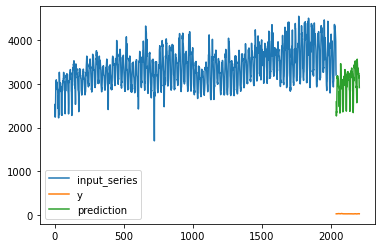

In [162]:
plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(2040, 2040+168), test_arr[idx, :, 0], label='y')
plt.plot(np.arange(2040, 2040+168), pred, label='prediction')
plt.legend()

In [166]:
valid_pred_array=np.zeros([60, 168])
for idx in range(train_arr.shape[0]):
    try:
        try:
            x_series=train_arr[idx, :, 0]
            model=ARIMA(x_series, order=(5, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
        except:
            print("order 4,1,1")
            
            x_series=train_arr[idx, :, 0]
            model=ARIMA(x_series, order=(4, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

In [169]:
submission = pd.read_csv('energy/sample_submission.csv', encoding='cp949')
submission['answer'] = valid_pred_array.reshape(-1, 1)

In [171]:
submission.to_csv('arima_baseline.csv', index=False)

# LSTM